<h1><center>Credit Risk Analysis using IBM PowerAI Snap ML</center></h1>

In this example we will train a Logistic Regression model on customers' credit history dataset, using scikit-learn, snapml, SnapBoost and XGBoost.
Update device_ids list in LogisticRegression of snap_ml based on the number of GPUs available for you.

To avoid 'kernel restart' problem increase CPU and memory for the jupyter environment (e.g. memory 10GB, CPU 100) and restart it

In [30]:
#https://www.ibm.com/support/knowledgecenter/SS5SF7_1.7.0/navigation/wmlce_install.html
#https://ibmsoe.github.io/snap-ml-doc/v1.6.0/manual.html

#Make sure you are running this jupyter notebook in a conda environment (recommended). 
#Steps on setting up the repo for WMLCE and conda env are in the next 3 lines and should be installed on the hostOS
#x86 or POWER

#conda config --prepend channels \
#https://public.dhe.ibm.com/ibmdl/export/pub/software/server/ibm-ai/conda/
#conda create -y -n my-170-env python=3.6 powerai=1.7.0

#Run the same command if your cuda version is NOT 10.2
#!conda install cudatoolkit

#Make sure you installed these packages, else you can uncomment and do it here.
#!conda install -y pandas
#!conda install -y scikit-learn
#!conda install -y matplotlib
#!conda install -y numpy
#!conda install -y seaborn
#!conda install -y py-xgboost-gpu
#SnapML installation
#!conda install -y pai4sk


### Download input dataset of customers' information

Two wget commands are given below for downloading input dataset - one for reduced dataset and another for bigger/full dataset. Many times better perfomance of snapML training is seen with bigger dataset.

You can comment out downloading code below if running the same wget command more than once.

In [114]:
# Many times better training time with snapML compared to sklearn with this full dataset but it's 1 GB
# If it fails download the dataset manually and put it in the same folder as this notebook
#!wget -Nc --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1u_XXCFXfBmFwy5F7yzsrNHzuMK9oI_Tk' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1u_XXCFXfBmFwy5F7yzsrNHzuMK9oI_Tk" -O credit_customer_history.csv && rm -rf /tmp/cookies.txt


# Many times better training time with snapML compared to sklearn with this full dataset (Broken)
#!wget -O credit_customer_history.csv -nc https://ibm.box.com/shared/static/c84jns0hy2ty05t3c3a9c17ca1mxpe6s.csv

# Download reduced dataset 100 MB (Broken)
#!wget -O credit_customer_history.csv https://ibm.box.com/shared/static/tr7cz4drh7bwa8kbyw0erjfjh7fort0y.csv

for details.

--2020-02-24 17:03:13--  https://docs.google.com/uc?export=download&confirm=0GAW&id=1u_XXCFXfBmFwy5F7yzsrNHzuMK9oI_Tk
Resolving docs.google.com (docs.google.com)... 2404:6800:4005:804::200e, 172.217.24.78
Connecting to docs.google.com (docs.google.com)|2404:6800:4005:804::200e|:443... failed: Connection timed out.
Connecting to docs.google.com (docs.google.com)|172.217.24.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/vafasrevk4ugq8sdb4lv111obsffhi4k/m5o50r6fchibhar83mqfup8h1l486a4g/1582534800000/09375525340952693403/09560975129892799572Z/1u_XXCFXfBmFwy5F7yzsrNHzuMK9oI_Tk?e=download [following]
--2020-02-24 17:05:27--  https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/vafasrevk4ugq8sdb4lv111obsffhi4k/m5o50r6fchibhar83mqfup8h1l486a4g/1582534800000/09375525340952693403/09560975129892799572Z/1u_XXCFXfBmFwy5F7yzsrNHzuMK9oI_Tk?e=download
Resolving doc-0g-0k-docs.g

In [109]:
# Check your GPU(s). Make sure your GPU Driver is 440.X and CUDA is 10.2 

In [3]:
!nvidia-smi

Tue Feb 25 14:09:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000002:01:00.0 Off |                    0 |
| N/A   41C    P0    47W / 300W |   4049MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-SXM2...  On   | 00000003:01:00.0 Off |                    0 |
| N/A   41C    P0    32W / 300W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### imports

In [4]:
from __future__ import print_function
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from scipy.stats import chi2_contingency,ttest_ind
from sklearn.utils import shuffle
import time

import warnings
warnings.filterwarnings('ignore')


In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [6]:
!mv credit_customer_history*csv credit_customer_history.csv

mv: 'credit_customer_history.csv' and 'credit_customer_history.csv' are the same file


# Dataset Visualization


Let's take a quick look at the dataset.


In [7]:
cust_pd_full = pd.read_csv('/home/gilbert/notebooks/credit_customer_history.csv')

rows=1000000
cust_pd = cust_pd_full.head(rows)
print("There are " + str(len(cust_pd_full)) + " observations in the customer history dataset.")
print("There are " + str(len(cust_pd_full.columns)) + " variables in the dataset.")

cust_pd.head()

There are 10000000 observations in the customer history dataset.
There are 19 variables in the dataset.


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL,IS_DEFAULT
0,77,EXISTING CREDITS PAID BACK,EDUCATION,27630,UNKNOWN/NONE,above 7 YRS,CT,NO,YES,YES,YES,NO,YES,NO,0,4,NO,NO,No
1,119,EXISTING CREDITS PAID BACK,ELECTRONICS,31314,above 1000 K USD,4 to 7 YRS,CT,YES,YES,YES,YES,NO,NO,YES,0,3,YES,YES,No
2,84,EXISTING CREDITS PAID BACK,FURNITURE,27630,above 1000 K USD,4 to 7 YRS,PA,NO,NO,YES,YES,YES,NO,YES,0,3,YES,YES,No
3,119,DELAY IN PAST,FURNITURE,33156,above 1000 K USD,up to 1 YR,PA,YES,NO,YES,NO,NO,NO,YES,0,3,NO,NO,Yes
4,105,DELAY IN PAST,FURNITURE,23946,above 1000 K USD,up to 1 YR,CT,NO,YES,YES,YES,YES,YES,NO,0,3,YES,YES,No


# distribution of output variable default

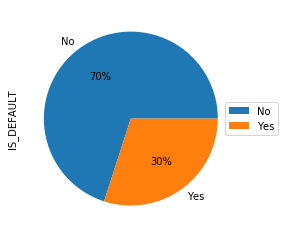

In [8]:
#cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',colormap='winter',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.6))
cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.6))

# Default by Credit Program

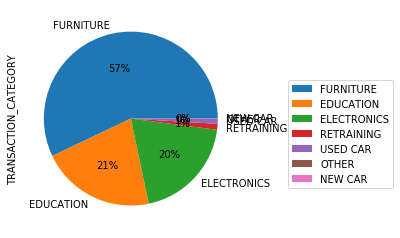

In [9]:
cust_pd.TRANSACTION_CATEGORY.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.7))

* Top 3 credit programs with most Merchants are Electronics(28%), New Car(23.4%) and Furniture(18.1%).

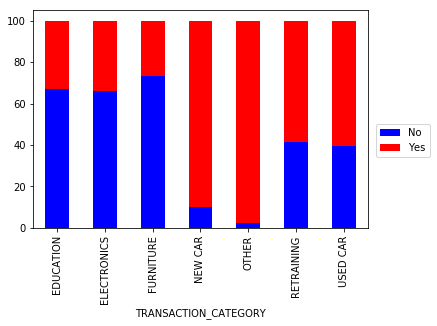

In [10]:
defaults_by_credit_program = cust_pd.groupby(['TRANSACTION_CATEGORY','IS_DEFAULT']).size()
percentages = defaults_by_credit_program.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(bbox_to_anchor=(1.2, 0.5))

* Top 3 credit programs with high default rate are Education(44%), New Car(38%), and Retraining(35.1%)


# Default by IS_STATE_BORDER


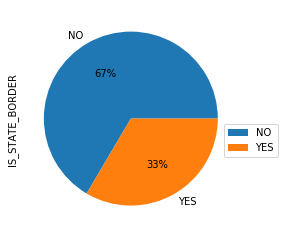

In [11]:
cust_pd.IS_STATE_BORDER.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.5))

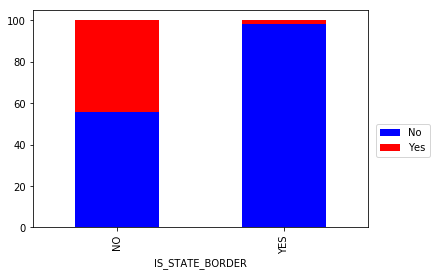

In [12]:
defaults_by_xborder = cust_pd.groupby(['IS_STATE_BORDER','IS_DEFAULT']).size()
percentages = defaults_by_xborder.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,  color=['blue','red'], grid=False).legend(bbox_to_anchor=(1.2, 0.5))

# HAS_CO_APPLICANT vs. IS_DEFAULT

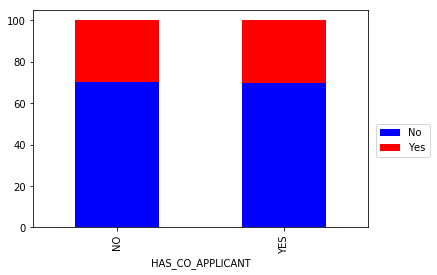

In [13]:
defaults_by_rent = cust_pd.groupby(['HAS_CO_APPLICANT','IS_DEFAULT']).size()
percentages = defaults_by_rent.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,  color=['blue','red'], grid=False).legend(bbox_to_anchor=(1.2, 0.5))

From this stacked bar chart, we can see that Merchants who rent their residence have higher default rate.

# CREDIT_HISTORY vs. IS_DEFAULT

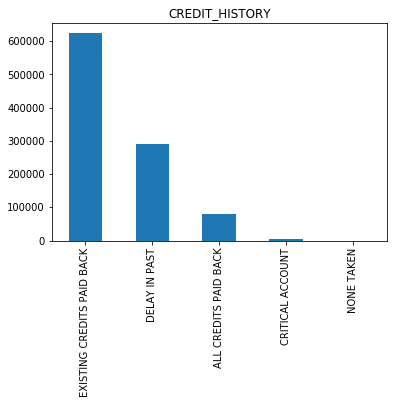

In [14]:
cust_pd.CREDIT_HISTORY.value_counts().plot(kind='bar', title='CREDIT_HISTORY')

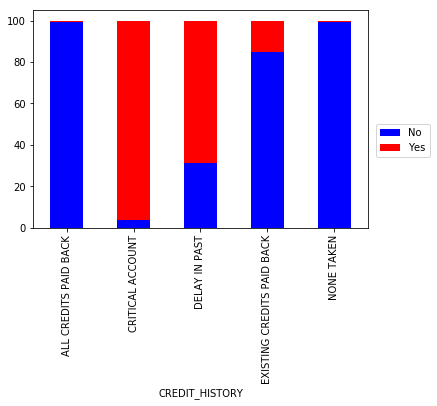

In [15]:
defaults_by_history = cust_pd.groupby(['CREDIT_HISTORY','IS_DEFAULT']).size()
percentages = defaults_by_history.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(bbox_to_anchor=(1.2, 0.5))

# Data Preparation

In [16]:
#cust_pd = cust_pd.sort_values(['IS_DEFAULT'],ascending=[False])
#cust_pd = shuffle(cust_pd)
cust_pd = cust_pd_full
cust_pd.head()


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL,IS_DEFAULT
0,77,EXISTING CREDITS PAID BACK,EDUCATION,27630,UNKNOWN/NONE,above 7 YRS,CT,NO,YES,YES,YES,NO,YES,NO,0,4,NO,NO,No
1,119,EXISTING CREDITS PAID BACK,ELECTRONICS,31314,above 1000 K USD,4 to 7 YRS,CT,YES,YES,YES,YES,NO,NO,YES,0,3,YES,YES,No
2,84,EXISTING CREDITS PAID BACK,FURNITURE,27630,above 1000 K USD,4 to 7 YRS,PA,NO,NO,YES,YES,YES,NO,YES,0,3,YES,YES,No
3,119,DELAY IN PAST,FURNITURE,33156,above 1000 K USD,up to 1 YR,PA,YES,NO,YES,NO,NO,NO,YES,0,3,NO,NO,Yes
4,105,DELAY IN PAST,FURNITURE,23946,above 1000 K USD,up to 1 YR,CT,NO,YES,YES,YES,YES,YES,NO,0,3,YES,YES,No


## Split Dataframe into Features and Label

In [17]:
cust_pd_Y = cust_pd[['IS_DEFAULT']]
cust_pd_X = cust_pd.drop(['IS_DEFAULT'],axis=1)

print('cust_pd_X.shape=', cust_pd_X.shape, 'cust_pd_Y.shape=', cust_pd_Y.shape)


cust_pd_X.shape= (10000000, 18) cust_pd_Y.shape= (10000000, 1)


## Transform Label

In [18]:
cust_pd_Y.head()

,IS_DEFAULT
0,No
1,No
2,No
3,Yes
4,No


In [19]:
le = LabelEncoder()
cust_pd_Y['IS_DEFAULT'] = le.fit_transform(cust_pd_Y['IS_DEFAULT'])
cust_pd_Y.head()

,IS_DEFAULT
0,0
1,0
2,0
3,1
4,0


## Transform Features

In [20]:
print('features df shape = ', cust_pd_X.shape)
cust_pd_X.head()

features df shape =  (10000000, 18)


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL
0,77,EXISTING CREDITS PAID BACK,EDUCATION,27630,UNKNOWN/NONE,above 7 YRS,CT,NO,YES,YES,YES,NO,YES,NO,0,4,NO,NO
1,119,EXISTING CREDITS PAID BACK,ELECTRONICS,31314,above 1000 K USD,4 to 7 YRS,CT,YES,YES,YES,YES,NO,NO,YES,0,3,YES,YES
2,84,EXISTING CREDITS PAID BACK,FURNITURE,27630,above 1000 K USD,4 to 7 YRS,PA,NO,NO,YES,YES,YES,NO,YES,0,3,YES,YES
3,119,DELAY IN PAST,FURNITURE,33156,above 1000 K USD,up to 1 YR,PA,YES,NO,YES,NO,NO,NO,YES,0,3,NO,NO
4,105,DELAY IN PAST,FURNITURE,23946,above 1000 K USD,up to 1 YR,CT,NO,YES,YES,YES,YES,YES,NO,0,3,YES,YES


### One hot encoding for categorical Columns

In [21]:
categoricalColumns = ['CREDIT_HISTORY', 'TRANSACTION_CATEGORY', 'ACCOUNT_TYPE', 'ACCOUNT_AGE',
                      'STATE', 'IS_URBAN', 'IS_STATE_BORDER', 'HAS_CO_APPLICANT', 'HAS_GUARANTOR',
                      'OWN_REAL_ESTATE', 'OTHER_INSTALMENT_PLAN',
                      'OWN_RESIDENCE', 'RFM_SCORE', 'OWN_CAR', 'SHIP_INTERNATIONAL']
cust_pd_X = pd.get_dummies(cust_pd_X, columns=categoricalColumns)

cust_pd_X.head()

,EMI_TENURE,TRANSACTION_AMOUNT,NUMBER_CREDITS,CREDIT_HISTORY_ALL CREDITS PAID BACK,CREDIT_HISTORY_CRITICAL ACCOUNT,CREDIT_HISTORY_DELAY IN PAST,CREDIT_HISTORY_EXISTING CREDITS PAID BACK,CREDIT_HISTORY_NONE TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED CAR,ACCOUNT_TYPE_100 to 500 K USD,ACCOUNT_TYPE_500 to 1000 K USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above 1000 K USD,ACCOUNT_TYPE_up to 100 K USD,ACCOUNT_AGE_1 to 4 YRS,ACCOUNT_AGE_4 to 7 YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above 7 YRS,ACCOUNT_AGE_up to 1 YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES
0,77,27630,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,1,1,0,1,0
1,119,31314,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1
2,84,27630,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1
3,119,33156,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
4,105,23946,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1


## Normalize Features

In [22]:
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(cust_pd_X)
features = normalize(features, axis=1, norm='l1')

cust_pd_X = pd.DataFrame(features,columns=cust_pd_X.columns)
cust_pd_X.head()

,EMI_TENURE,TRANSACTION_AMOUNT,NUMBER_CREDITS,CREDIT_HISTORY_ALL CREDITS PAID BACK,CREDIT_HISTORY_CRITICAL ACCOUNT,CREDIT_HISTORY_DELAY IN PAST,CREDIT_HISTORY_EXISTING CREDITS PAID BACK,CREDIT_HISTORY_NONE TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED CAR,ACCOUNT_TYPE_100 to 500 K USD,ACCOUNT_TYPE_500 to 1000 K USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above 1000 K USD,ACCOUNT_TYPE_up to 100 K USD,ACCOUNT_AGE_1 to 4 YRS,ACCOUNT_AGE_4 to 7 YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above 7 YRS,ACCOUNT_AGE_up to 1 YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES
0,0.027542,0.033533,0.0,0.0,0.0,0.000000,0.062595,0.0,0.062595,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062595,0.000000,0.0,0.0,0.000000,0.0,0.062595,0.000000,0.062595,0.0,0.0,0.000000,0.062595,0.000000,0.000000,0.062595,0.0,0.062595,0.000000,0.062595,0.062595,0.000000,0.000000,0.062595,0.062595,0.000000,0.0,0.0,0.000000,0.062595,0.062595,0.000000,0.062595,0.000000
1,0.041751,0.037277,0.0,0.0,0.0,0.000000,0.061398,0.0,0.000000,0.061398,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.061398,0.0,0.0,0.061398,0.0,0.000000,0.000000,0.061398,0.0,0.0,0.000000,0.000000,0.061398,0.000000,0.061398,0.0,0.061398,0.000000,0.061398,0.061398,0.000000,0.061398,0.000000,0.000000,0.061398,0.0,0.0,0.061398,0.000000,0.000000,0.061398,0.000000,0.061398
2,0.029971,0.033449,0.0,0.0,0.0,0.000000,0.062439,0.0,0.000000,0.000000,0.062439,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062439,0.0,0.0,0.062439,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.062439,0.062439,0.000000,0.062439,0.000000,0.0,0.062439,0.000000,0.062439,0.000000,0.062439,0.062439,0.000000,0.000000,0.062439,0.0,0.0,0.062439,0.000000,0.000000,0.062439,0.000000,0.062439
3,0.041659,0.039384,0.0,0.0,0.0,0.061264,0.000000,0.0,0.000000,0.000000,0.061264,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.061264,0.0,0.0,0.000000,0.0,0.000000,0.061264,0.000000,0.0,0.0,0.061264,0.000000,0.061264,0.061264,0.000000,0.0,0.061264,0.061264,0.000000,0.061264,0.000000,0.061264,0.000000,0.000000,0.061264,0.0,0.0,0.061264,0.000000,0.061264,0.000000,0.061264,0.000000
4,0.037350,0.028902,0.0,0.0,0.0,0.062250,0.000000,0.0,0.000000,0.000000,0.062250,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062250,0.0,0.0,0.000000,0.0,0.000000,0.062250,0.062250,0.0,0.0,0.000000,0.062250,0.000000,0.000000,0.062250,0.0,0.062250,0.000000,0.062250,0.000000,0.062250,0.000000,0.062250,0.062250,0.000000,0.0,0.0,0.062250,0.000000,0.000000,0.062250,0.000000,0.062250


## Split Train and Test Dataset

In [23]:
label    = cust_pd_Y.values
features  = cust_pd_X.values

label = np.reshape(label,(-1,1))
X_train,X_test,y_train,y_test = \
       train_test_split(features, label, test_size=0.3, random_state=42, stratify=label)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)




X_train.shape= (7000000, 51) Y_train.shape= (7000000, 1)
X_test.shape= (3000000, 51) Y_test.shape= (3000000, 1)


# Train a Logistic Regression Model using Scikit-Learn

In [24]:
from sklearn.linear_model import LogisticRegression
sklearn_lr = LogisticRegression() 

In [25]:
# Train a logistic regression model using Scikit-Learn
t0 = time.time()
sklearn_lr.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[sklearn] Training time (s):  {0:.2f}".format(sklearn_time))

# Evaluate accuracy on test set
sklearn_pred = sklearn_lr.predict(X_test)
print('[sklearn] Accuracy score : {0:.6f}'.format(accuracy_score(y_test, sklearn_pred)))

[sklearn] Training time (s):  105.44
[sklearn] Accuracy score : 0.959743


# Train a Logistic Regression Model using Snap ML

In [26]:
from pai4sk import LogisticRegression
#snapml_lr = LogisticRegression(use_gpu=True, device_ids=[0], num_threads=32)
#Use the below if you running on Power with at least 2 GPUs
snapml_lr = LogisticRegression(use_gpu=True, device_ids=[0,1], num_threads=128)

In [27]:
# Train a logistic regression model using Snap ML
import time
t0 = time.time()
model = snapml_lr.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

# Evaluate accuracy on test set
snapml_pred = snapml_lr.predict(X_test)
print('[Snap ML] Accuracy score : {0:.6f}'.format(accuracy_score(y_test, snapml_pred)))
print('[Logistic Regression] Snap ML vs. sklearn speedup : {0:.2f}x '.format(sklearn_time/snapml_time))

[Snap ML] Training time (s):  2.44051
[Snap ML] Accuracy score : 0.959836
[Logistic Regression] Snap ML vs. sklearn speedup : 43.20x 


# Train a Random Forest Model using Scikit-Learn

In [28]:
# Import the Random Forest model from the pai4sk package
from sklearn.ensemble import RandomForestClassifier
sklearn_rf = RandomForestClassifier(n_estimators=16, n_jobs=8, random_state=0)

In [29]:
# Training a random forest model using scikit-learn
t0 = time.time()
sklearn_rf.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[sklearn] Training time (s):  {0:.5f}".format(sklearn_time))

# Evaluate accuracy on test set
sklearn_pred = sklearn_rf.predict(X_test)
print('[sklearn] Accuracy score : ', accuracy_score(y_test, sklearn_pred))

[sklearn] Training time (s):  181.17282
[sklearn] Accuracy score :  0.9800816666666666


# Train a Random Forest Model using Snap ML

In [31]:
# Import the Random Forest model directly from the SnapML package
from pai4sk import RandomForestClassifier
#Use the below line for snapml with CPU
#snapml_rf = RandomForestClassifier(n_estimators=16, n_jobs=8, random_state=0)
#Use the below for snapml with 1 GPU
#snapml_rf = RandomForestClassifier(n_estimators=16, n_jobs=8, random_state=0, max_depth=16, use_histograms=True,use_gpu=True, gpu_ids=[0])
#Use the below for snapml with 2GPU
snapml_rf = RandomForestClassifier(n_estimators=16, n_jobs=8, random_state=0, max_depth=16, use_histograms=True,use_gpu=True, gpu_ids=[0,1])

In [32]:
# Training a random forest model using Snap ML
t0 = time.time()
snapml_rf.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

# Evaluate accuracy on test set
snapml_pred = snapml_rf.predict(X_test, num_threads=128)
#print(snapml_pred)
print('[Snap ML] Accuracy score : {0:.6f}'.format(accuracy_score(y_test, snapml_pred)))
print('[Random Forest] Snap ML vs. sklearn speedup : {0:.2f}x '.format(sklearn_time/snapml_time))

[Snap ML] Training time (s):  17.72028
[Snap ML] Accuracy score : 0.978821
[Random Forest] Snap ML vs. sklearn speedup : 10.22x 


# Train a Random Forest Model using SnapBoost

In [33]:
from pai4sk import BoostingMachine
#Use the below if 
#snapboost = BoostingMachine(random_state=0,objective='logloss', use_gpu=False)
snapboost = BoostingMachine(random_state=0,objective='logloss', use_histograms=True, use_gpu=True)
#Snapboost on GPU only works with use_histogram=True

In [34]:
t0 = time.time()
snapboost.fit(X_train, y_train)
snapboost_time = time.time()-t0
print("[SnapBoost] Training time (s):  {0:.5f}".format(snapboost_time))

# Evaluate accuracy on test set
snapboost_pred = snapboost.predict(X_test)
snapboost_pred[snapboost_pred < 0] = 0
snapboost_pred[snapboost_pred > 0] = 1
#print(snapboost_pred)
print('[SnapBoost] Accuracy score : {0:.6f}'.format(accuracy_score(y_test, snapboost_pred)))
print('[Random Forest] SnapBoost vs. sklearn speedup : {0:.2f}x '.format(sklearn_time/snapboost_time))

[SnapBoost] Training time (s):  9.25527
[SnapBoost] Accuracy score : 0.951593
[Random Forest] SnapBoost vs. sklearn speedup : 19.58x 


# Train a Random Forest Model using XGBoost

In [35]:
import xgboost as xgb
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split

In [36]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [37]:
param_gpu = {'objective': 'binary:logistic', # Specify multiclass classification
             'num_class': 1, # Number of possible output classes
             'tree_method': 'gpu_hist', # Use GPU accelerated algorithm
             'n_gpus': 1, # Use one GPU
             'gpu_id': 0  # Use GPU with device-id 0
            }

In [38]:
# To train a model with higher accuracy num_rounds has to be increased e.g. 3000
# as shown in here https://github.com/dmlc/xgboost/blob/bf3241368256ddd010d30d98ffc8a0a005f166e9/demo/gpu_acceleration/cover_type.py#L17
# but it takes a very long time to train in a CPU!
# Reduced the num_rounds to a very low value for CPU training to complete in reasonable time
num_round = 20

In [39]:
gpu_res = {} # Store accuracy result
tmp = time.time()
bst = xgb.train(param_gpu, dtrain, num_round, evals=[(dtest, 'test')], evals_result=gpu_res)
xgboost_pred = bst.predict(dtest)
predictions = [round(value) for value in xgboost_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("[XGBoost] Training time (s):  {0:.5f}".format((time.time() - tmp)))
print("[XGBoost] Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	test-error:0.048605
[1]	test-error:0.043363
[2]	test-error:0.041687
[3]	test-error:0.037812
[4]	test-error:0.036709
[5]	test-error:0.035717
[6]	test-error:0.034513
[7]	test-error:0.03351
[8]	test-error:0.032235
[9]	test-error:0.03216
[10]	test-error:0.031375
[11]	test-error:0.030658
[12]	test-error:0.02935
[13]	test-error:0.02824
[14]	test-error:0.027605
[15]	test-error:0.027129
[16]	test-error:0.026767
[17]	test-error:0.025649
[18]	test-error:0.025436
[19]	test-error:0.025159
[XGBoost] Training time (s):  17.79379
[XGBoost] Accuracy: 97.48%


In [61]:
#https://ibmsoe.github.io/snap-ml-doc/v1.5.0/index.html
#Original code from Haris Pozidis
#Modified by Gilbert Thomas on Feb 23rd 2020 
#Added SnapBoost
#Added XGBoost
#Changed link to dataset as box link is broken.
#Added dependencies at the top


&copy; Copyright IBM Corporation 2018, 2020